# Gradient Descent Tutorial
This tutorial demonstrates how to use the C++ gradient descent library with Python bindings.
### Setup
Make sure you've built the module using:
```bash
cd src/notebooks/
python3 setup.py build_ext --inplace
```

In [1]:
import sys
import numpy as np
import gradientdescent as gd

print("Gradient Descent module loaded successfully!")

Gradient Descent module loaded successfully!


## Part 1: Automatic Differentiation

In [2]:
# Create variables
x = gd.Variable.create(2.0, True)  # requires_grad=True
y = gd.Variable.create(3.0, True)

print(f"x = {x}")
print(f"y = {y}")

x = 2.000000
y = 3.000000


In [3]:
# Arithmetic operations
z1 = x + y
z2 = x * y
z3 = x - y
z4 = x / y

print(f"x + y = {z1.value}")
print(f"x * y = {z2.value}")
print(f"x - y = {z3.value}")
print(f"x / y = {z4.value}")

x + y = 5.0
x * y = 6.0
x - y = -1.0
x / y = 0.6666666666666666


In [4]:
# Simple gradient: f(x) = x^2, df/dx = 2x
x = gd.Variable.create(3.0, True)
f = x * x

print(f"f(x) = x^2 where x = {x.value}")
print(f"f = {f.value}")

f.backward()
print(f"df/dx = {x.grad} (expected: {2 * x.value})")

f(x) = x^2 where x = 3.0
f = 9.0
df/dx = 6.0 (expected: 6.0)


In [5]:
# Complex multivariate function using all operations:
# f(x,y,z) = exp(x*y) * sin(z) + tanh(x/y) * cos(y^2) + log(x+1) * (z-y)^3

import numpy as np

x = gd.Variable.create(2.0, True)
y = gd.Variable.create(1.5, True) 
z = gd.Variable.create(0.8, True)

# Term 1: exp(x*y) * sin(z)
xy = x * y
exp_xy = xy.exp()
sin_z = z.sin()
term1 = exp_xy * sin_z

# Term 2: tanh(x/y) * cos(y^2)
x_div_y = x / y
tanh_term = x_div_y.tanh()
y_squared = y.pow(gd.Variable.create(2.0))
cos_y2 = y_squared.cos()
term2 = tanh_term * cos_y2

# Term 3: log(x+1) * (z-y)^3
x_plus_1 = x + gd.Variable.create(1.0)
log_term = x_plus_1.log()
z_minus_y = z - y
cube_term = z_minus_y.pow(gd.Variable.create(3.0))
term3 = log_term * cube_term

# Final function
f = term1 + term2 + term3

print(f"f(x={x.value}, y={y.value}, z={z.value}) = {f.value:.6f}")
print(f"\nTerm 1 (exp(x*y)*sin(z)): {term1.value:.6f}")
print(f"Term 2 (tanh(x/y)*cos(y²)): {term2.value:.6f}")
print(f"Term 3 (log(x+1)*(z-y)³): {term3.value:.6f}")

# Compute gradients
f.backward()

print(f"\nGradients:")
print(f"∂f/∂x = {x.grad:.6f}")
print(f"∂f/∂y = {y.grad:.6f}")
print(f"∂f/∂z = {z.grad:.6f}")

# Calculate expected values using numpy/math for verification
x_val, y_val, z_val = 2.0, 1.5, 0.8

# Expected function value
exp_term1 = np.exp(x_val * y_val) * np.sin(z_val)
exp_term2 = np.tanh(x_val / y_val) * np.cos(y_val**2)
exp_term3 = np.log(x_val + 1) * (z_val - y_val)**3
exp_f = exp_term1 + exp_term2 + exp_term3

# Expected gradients
# ∂f/∂x = y*exp(x*y)*sin(z) + (1-tanh²(x/y))*(1/y)*cos(y²) + (1/(x+1))*(z-y)³
exp_df_dx = (y_val * np.exp(x_val * y_val) * np.sin(z_val) + 
             (1 - np.tanh(x_val/y_val)**2) * (1/y_val) * np.cos(y_val**2) + 
             (1/(x_val+1)) * (z_val-y_val)**3)

# ∂f/∂y = x*exp(x*y)*sin(z) - (1-tanh²(x/y))*(x/y²)*cos(y²) - 2*y*tanh(x/y)*sin(y²) - 3*log(x+1)*(z-y)²
exp_df_dy = (x_val * np.exp(x_val * y_val) * np.sin(z_val) - 
             (1 - np.tanh(x_val/y_val)**2) * (x_val/y_val**2) * np.cos(y_val**2) - 
             2 * y_val * np.tanh(x_val/y_val) * np.sin(y_val**2) - 
             3 * np.log(x_val+1) * (z_val-y_val)**2)

# ∂f/∂z = exp(x*y)*cos(z) + 3*log(x+1)*(z-y)²
exp_df_dz = (np.exp(x_val * y_val) * np.cos(z_val) + 
             3 * np.log(x_val+1) * (z_val-y_val)**2)

print("\nExpected values:")
print(f"f(x,y,z) = {exp_f:.6f}")
print(f"∂f/∂x = {exp_df_dx:.6f}")
print(f"∂f/∂y = {exp_df_dy:.6f}")
print(f"∂f/∂z = {exp_df_dz:.6f}")

# Compare results
print("\nDifference (autodiff - expected):")
print(f"f: {f.value - exp_f:.6e}")
print(f"∂f/∂x: {x.grad - exp_df_dx:.6e}")
print(f"∂f/∂y: {y.grad - exp_df_dy:.6e}")
print(f"∂f/∂z: {z.grad - exp_df_dz:.6e}")


f(x=2.0, y=1.5, z=0.8) = 13.485108

Term 1 (exp(x*y)*sin(z)): 14.408482
Term 2 (tanh(x/y)*cos(y²)): -0.546550
Term 3 (log(x+1)*(z-y)³): -0.376824

Gradients:
∂f/∂x = 21.396629
∂f/∂y = 25.306771
∂f/∂z = 15.608688

Expected values:
f(x,y,z) = 13.485108
∂f/∂x = 21.396629
∂f/∂y = 25.306771
∂f/∂z = 15.608688

Difference (autodiff - expected):
f: 0.000000e+00
∂f/∂x: 0.000000e+00
∂f/∂y: 0.000000e+00
∂f/∂z: 0.000000e+00


## Part 2: Linear Regression with Gradient Descent

In [6]:
# Generate synthetic data for linear regression
np.random.seed(42)
n_samples = 100
n_features = 2

# True parameters: w = [2.5, -1.5], bias = 1.0
true_w = np.array([2.5, -1.5])
true_b = 1.0

# Generate random X data
X = np.random.randn(n_samples, n_features)

# Generate y = X * w + bias + noise
y = X.dot(true_w) + true_b + np.random.randn(n_samples) * 0.5

# Add bias column to X (column of ones)
X_with_bias = np.column_stack([X, np.ones(n_samples)])
true_params = np.append(true_w, true_b)

print(f"Generated {n_samples} samples with {n_features} features + bias")
print(f"True parameters: {true_params}")

Generated 100 samples with 2 features + bias
True parameters: [ 2.5 -1.5  1. ]


In [7]:
# Convert data to the format expected by our C++ code
X_list = X_with_bias.tolist()
y_list = y.tolist()

# Initialize weights with random values (including bias weight)
w = [gd.Variable.create(np.random.randn(), True) for _ in range(n_features + 1)]
print(f"Initial weights: [{w[0].value:.4f}, {w[1].value:.4f}, {w[2].value:.4f}] (last is bias)")

# Create loss function and optimizer
loss_fn = gd.MSE()
optimizer = gd.Vanilla()

Initial weights: [-0.8290, -0.5602, 0.7473] (last is bias)


In [8]:
# Training parameters
learning_rate = 1e-2
n_epochs = 2500

# Training loop
losses = []
weights_history = []

for epoch in range(n_epochs):
    # Train one step
    optimizer.train(w, X_list, y_list, loss_fn, learning_rate)
    
    # Compute current predictions and loss for monitoring
    y_pred = []
    for i in range(n_samples):
        pred = gd.Variable.create(0.0)
        for j in range(n_features + 1):
            x_ij = gd.Variable.create(X_list[i][j])
            pred = pred + w[j] * x_ij
        y_pred.append(pred)
    
    loss = loss_fn.compute(y_pred, y_list)
    losses.append(loss.value)
    weights_history.append([w[0].value, w[1].value, w[2].value])

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.value:.6f}, Weights = [{w[0].value:.4f}, {w[1].value:.4f}, {w[2].value:.4f}]")

print(f"\nFinal weights: [{w[0].value:.4f}, {w[1].value:.4f}, {w[2].value:.4f}]")
print(f"True parameters: [{true_params[0]:.4f}, {true_params[1]:.4f}, {true_params[2]:.4f}]")

Epoch 0: Loss = 9.377244, Weights = [-0.7795, -0.5787, 0.7447]
Epoch 10: Loss = 7.026936, Weights = [-0.3233, -0.7456, 0.7274]
Epoch 20: Loss = 5.295777, Weights = [0.0703, -0.8841, 0.7232]
Epoch 30: Loss = 4.016718, Weights = [0.4100, -0.9990, 0.7284]
Epoch 40: Loss = 3.069042, Weights = [0.7033, -1.0946, 0.7399]
Epoch 50: Loss = 2.365119, Weights = [0.9567, -1.1741, 0.7557]
Epoch 60: Loss = 1.841067, Weights = [1.1757, -1.2404, 0.7741]
Epoch 70: Loss = 1.450135, Weights = [1.3651, -1.2956, 0.7938]
Epoch 80: Loss = 1.157982, Weights = [1.5289, -1.3418, 0.8140]
Epoch 90: Loss = 0.939300, Weights = [1.6707, -1.3803, 0.8340]
Epoch 100: Loss = 0.775383, Weights = [1.7934, -1.4126, 0.8534]
Epoch 110: Loss = 0.652363, Weights = [1.8997, -1.4396, 0.8718]
Epoch 120: Loss = 0.559935, Weights = [1.9918, -1.4623, 0.8891]
Epoch 130: Loss = 0.490425, Weights = [2.0716, -1.4814, 0.9052]
Epoch 140: Loss = 0.438107, Weights = [2.1408, -1.4974, 0.9201]
Epoch 150: Loss = 0.398701, Weights = [2.2007, -1

In [9]:
# Training Results Summary
print("\n=== Training Results ===")
print(f"Final Loss: {losses[-1]:.6f}")
print(f"Loss Reduction: {((losses[0] - losses[-1]) / losses[0] * 100):.1f}%")
print(f"\nParameter Convergence:")
print(f"w[0]: {w[0].value:.4f} -> target: {true_params[0]:.4f} (error: {abs(w[0].value - true_params[0]):.4f})")
print(f"w[1]: {w[1].value:.4f} -> target: {true_params[1]:.4f} (error: {abs(w[1].value - true_params[1]):.4f})")
print(f"bias: {w[2].value:.4f} -> target: {true_params[2]:.4f} (error: {abs(w[2].value - true_params[2]):.4f})")


=== Training Results ===
Final Loss: 0.277509
Loss Reduction: 97.0%

Parameter Convergence:
w[0]: 2.5954 -> target: 2.5000 (error: 0.0954)
w[1]: -1.5861 -> target: -1.5000 (error: 0.0861)
bias: 1.0464 -> target: 1.0000 (error: 0.0464)


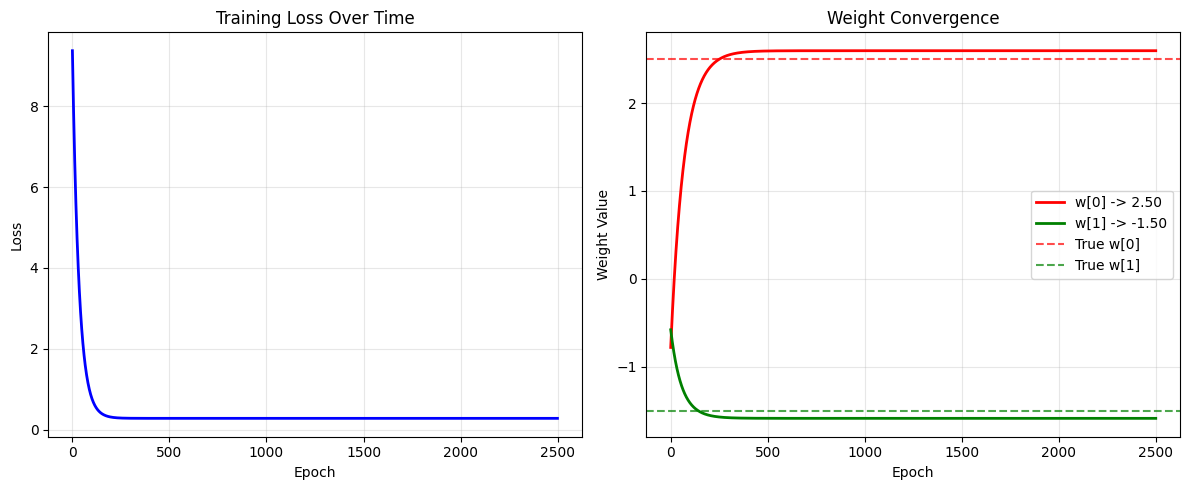

In [10]:
import matplotlib.pyplot as plt

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot loss over epochs
ax1.plot(losses, 'b-', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Over Time')
ax1.grid(True, alpha=0.3)

# Plot weight convergence
weights_history = np.array(weights_history)
ax2.plot(weights_history[:, 0], 'r-', label=f'w[0] -> {true_w[0]:.2f}', linewidth=2)
ax2.plot(weights_history[:, 1], 'g-', label=f'w[1] -> {true_w[1]:.2f}', linewidth=2)
ax2.axhline(y=true_w[0], color='r', linestyle='--', alpha=0.7, label='True w[0]')
ax2.axhline(y=true_w[1], color='g', linestyle='--', alpha=0.7, label='True w[1]')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Weight Value')
ax2.set_title('Weight Convergence')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()